## 1D wave equation
$$ \frac{\partial^2\phi}{\partial t^2}=v^2\frac{\partial^2\phi}{\partial x^2} $$
where $\phi$ is the wave amplitude, and $v$ is the wave speed.

Converted to a system of 2 first-order equations, discretized in space and time for FTCS:
$$ \phi(x,t+h) = \phi(x,t) + h \psi(x,t)$$
$$ \psi(x,t+h) = \psi(x,t) + \frac{h v^2}{a^2}((\phi(x+a,t) + \phi(x-a,t)-2\phi(x,t)) $$
with $h$ timestep, $a$ spatial grid spacing.


Consider a situation where $\phi$ corresponds to the vertical displacement of a string under tension, which is struck with a hammer a distance $d$ from one end. Then $v = \sqrt{T/\mu}$, with $T$ the tension in the string (in N) and $\mu$ the mass per unit length of the string (kg/m). 

Conditions:
* Boundary conditions: both ends of the string (at $x=0,~x=L$) remain fixed always.
* Initial conditions ($t=0$): $\phi = 0$ everywhere, $\psi(x) = \frac{Cx(L-x}{L^2} \exp \left( \frac{-(x-d)^2}{2 \sigma^2} \right)$
* Constants: $L=1, ~d = 0.1, ~C = 1, ~\sigma = 0.3, ~v = 100$ (all in SI units)
* Time-step: $h = 10^{-6}$ s
* Spatial grid: $a = 1$ cm

Simulate until $t = 0.1$ s, creating a plot every 0.01 s.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

L = 1.  # [m] Length of string
v = 100.  # [m/s] wave propagation speed
d = 0.10 # [m] location where string is hit
C = 1.  # [m/s] transverse velocity amplitude
sig = 0.3  # [m] typical width of initial disturbance
h = 1e-6  # [s] time step
a = 0.01  # [m] Grid step
tmax = 0.1 #[s] end of simulation time

xvals = np.arange(0, L+a, a) #spatial grid
N = len(xvals)

In [2]:
def init_psi(x):
    return C*x*(L-x)/L**2 * np.exp(-0.5*(x-d)**2/sig**2)

In [3]:
# Create spatial arrays for phi(t), psi(t), phi(t+h), psi(t+h)
phi = np.zeros(N, float)
psi = init_psi(xvals)
phi_next = np.zeros(N, float)
psi_next = np.empty(N, float)

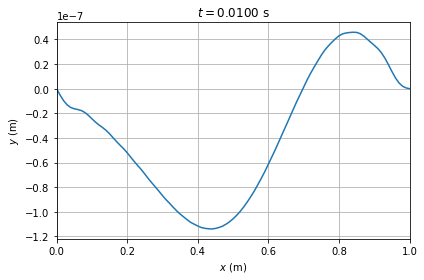

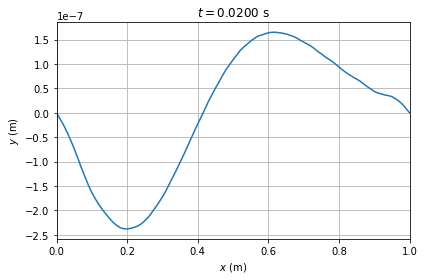

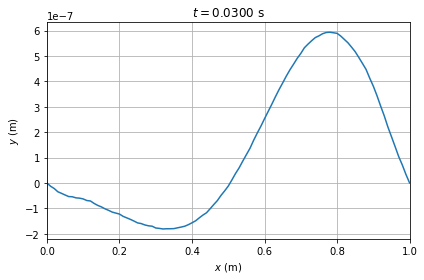

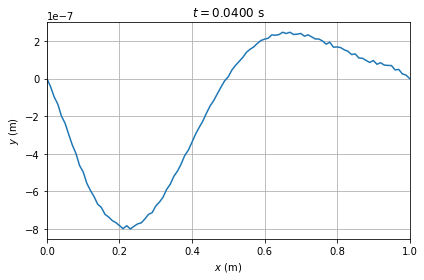

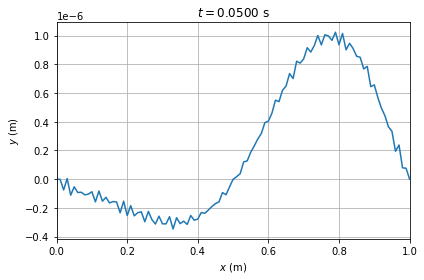

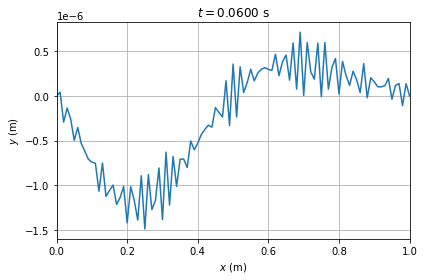

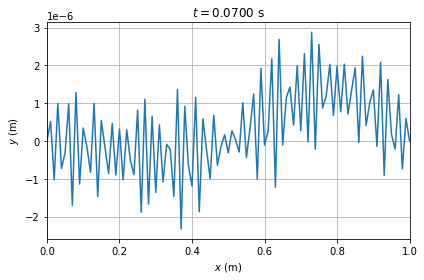

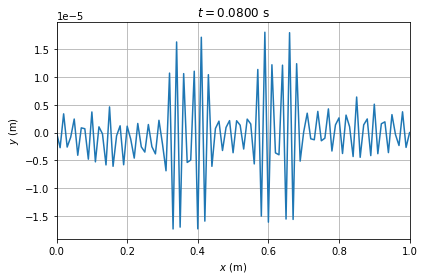

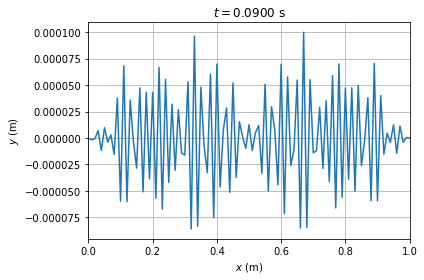

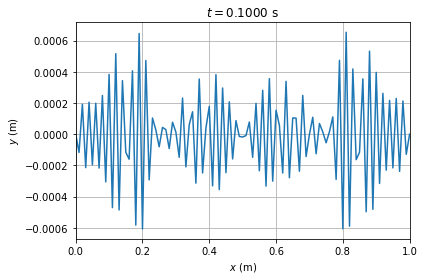

In [4]:
# main loop through time
t = 0.0
while max(abs(phi)) < L and t < tmax:
    # Calculate the new values of phi and psi
    for i in range(1, N-1):
        psi_next[i] = psi[i] + h*v**2/a**2*(phi[i+1] + phi[i-1] - 2*phi[i])
        phi_next[i] = phi[i] + h*psi[i]
    phi, phi_next = phi_next, phi
    psi, psi_next = psi_next, psi
    t += h
    
    #plots
    if int(t/h) % 10000 == 0:  # we skip every 1000 steps to speed up
        plt.figure(1)
        plt.clf()
        # Make a plot
        plt.plot(xvals, phi)
        plt.xlabel('$x$ (m)')
        plt.ylabel('$y$ (m)')
        plt.xlim([0., L])
        plt.title('$t = ${0:.4f} s'.format(t))
        plt.grid()
        plt.tight_layout()
        plt.draw()
        plt.show()
        #plt.pause(0.01)

We can see the solution becoming unstable about halfway through the simulated time interval!

## Burger's Equation

A classical nonlinear wave equation, which in 1D is:
$$ \frac{\partial u}{\partial t} + \epsilon u \frac{ \partial u}{\partial x} = 0 $$
or, in conservative form:
$$ \frac{\partial u}{\partial t} + \epsilon \frac{ \partial }{\partial x} \left ( \frac{u^2}{2} \right) = 0 $$
Burger's equation is like a wave propagation equation in which the phase speed of the wave $v$ is replaced by the actual wave velocity $u$.
This nonlinearity allows the wave to steepen and so is one way to model water waves approaching a beach.
As a model system, Burger's equation is the starting point for modelling solitons with the KdV (Korteweg-de Vries) equation (which includes an additional dispersion term).

Since the FTCS method is not appropriate to solve the wave equation, it won't work for Burgers equation either. One simple method that will work better, though not particularly efficient, is the leapfrog method ($i$ is time index, $j$ spatial index):
$$  \frac{u_i^{j+1} - u_i^{j-1}}{2\Delta t} = -\frac{\epsilon}2\frac{\left(u_{i+1}^j\right)^2 - \left(u^j_{i-1}\right)^2}{2\Delta x} $$
or
$$
  u_i^{j+1} = u_i^{j-1} - \frac{\beta}2\left[\left(u_{i+1}^j\right)^2 - \left(u^j_{i-1}\right)^2\right], \quad \text{with}\quad \beta = \epsilon\frac{\Delta t}{\Delta x} $$

Note you always need "starter" values at the edges of your space/time domain, for which the above equation does not apply.
In space, this is defined by the boundary values, while in time, you need to initiate the leapfrog stepping with one forward Euler step.

Write code implementing the above, with parameters for $\epsilon$, $\Delta x$, $\Delta t$ and the length of the spatial domain $L_x$ and for how long the simulation will be run, $T_f$. (Given $\Delta x$ and $L_x$, you can find $N_x$, and similarly for the time dimension.)

Run your code with:
* $\epsilon=1$, $\Delta x=0.02$, $\Delta t=0.005$, $L_x=2\pi$, $T_f=2$
* Initial condition $u(x,t=0)=\sin (x)$
* Boundary conditions $u(0,t)=0$ and $u(L_x,t)=0$.

Create and save plots of your solution at time $t=0$, $0.5$, $1$, $1.5$.

In [5]:
Lx = 2.*np.pi  # [m] length of domain
epsilon = 1.  # [] the non-linear parameter
Dt = 5e-3  # [s] time step
Dx = 2e-2  # [m] Grid step
Tf = 2.  # [s] duration of integration

t_record = [0.25, 0.5, 1., 1.5]  # the times of the snapshots
delta = Dt*0.5  # tolerance to detect when t_record is hit

In [6]:
# Dependent parameters
beta = epsilon*Dt/Dx

# Independent variables
x = np.arange(0, Lx+Dx, Dx)
Nx = len(x)

t = np.arange(0, Tf+Dt, Dt)
Nt = len(t)

# Create arrays
um = np.sin(x)  # mm for minus, i.e. j-1
u = np.empty(Nx, float)  # time step j
up = np.empty(Nx, float)  # p for plus, time step j+1
um[0] = 0.  # boundary conditions
um[-1] = 0.  # boundary conditions
u[0] = 0.  # boundary conditions
u[-1] = 0.  # boundary conditions
up[0] = 0.  # boundary conditions
up[-1] = 0.  # boundary conditions

u_record = np.empty((len(t_record), Nx), float)  # Snapshots for the solutions

In [7]:
# First time step
for i in range(1, Nx-1):  # note the boundaries stay at zero
    u[i] = um[i] - 0.25*beta*(um[i+1]**2 - um[i-1]**2)  # Mind the 0.25

# Main loop through time
ii = 0  # subplot counter
for tt, t_sec in enumerate(t):

    # Calculate the new values of u^{j+1}
    for i in range(1, Nx-1):
        up[i] = um[i] - .5*beta*(u[i+1]**2 - u[i-1]**2)

    # Make plots at the given times
    if abs(t_sec-t_record[ii]) < delta:
        u_record[ii, :] = up
        if ii < len(t_record)-1:
            ii += 1
            
    # next timestep        
    u = up
    um = u

/tmp/ipykernel_156/311280442.py:11: RuntimeWarning: overflow encountered in double_scalars
  up[i] = um[i] - .5*beta*(u[i+1]**2 - u[i-1]**2)
/tmp/ipykernel_156/311280442.py:11: RuntimeWarning: invalid value encountered in double_scalars
  up[i] = um[i] - .5*beta*(u[i+1]**2 - u[i-1]**2)


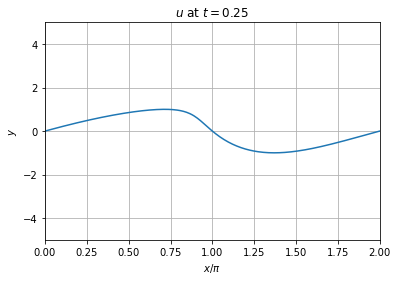

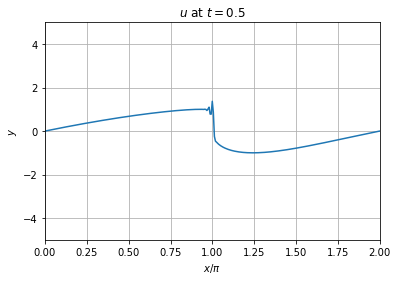

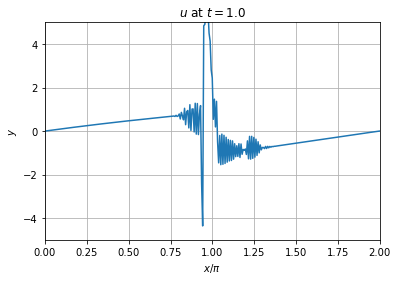

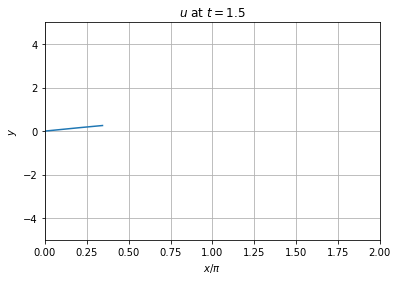

In [14]:
# Plotting
for ii in range(len(t_record)):
    plt.figure(ii+3)
    plt.plot(x/np.pi, u_record[ii, :])
    plt.xlabel("$x/\pi$")
    plt.ylabel("$y$")
    plt.xlim([0., Lx/np.pi])
    plt.ylim([-5., 5.])
    plt.title("$u$ at $t=${0:.4}".format(t_record[ii]))
    plt.grid()
    plt.show()

When we reach $t=1$, we see substantial "noise" in the solution, on the length scale of the computational grid.

Then the simulation becomes unstable: note the overflow RuntimeWarning that prevents the code from even finishing at $t=1.5$. 

So, leapfrog may be less unstable than FTCS, but still isn't stable enough here.